In [190]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn import metrics

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


## 1. data load

In [191]:
df = pd.read_csv("/Users/yj.noh/Desktop/on_boarding_data.csv", encoding = "cp949")
print(df.head(2))
print(df.isna().sum())

                                       brms_rider_id  birth delivery_method  \
0  E9AD475E050C07D27DE95100785EBE41480790A6D30E2E...   1980            WALK   
1  CAC046CE43D32CA3C29830A829D1E6FD3D7E11B397BF0F...   1970            BIKE   

  insurance_type first_available_date business_start_day  is_recom gender  \
0   NOT_REQUIRED           2020-07-21         2023-08-26         0    MAN   
1       PERSONAL           2020-09-12         2023-08-19         0    MAN   

   active_days  avg_daily_delivery  avg_distance      avg_fee  \
0            1                 7.0    434.571429  3187.142857   
1            2                36.5   2669.465753  6077.808219   

  last_working_day  outcome  
0       2023-08-26        1  
1       2023-08-20        1  
brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
active_days             0
avg_daily_

In [193]:
#data_filter = df[((df['day_cnt'].notnull()) & (df['delivery_method'] == 'BIKE') & (df['is_recom'] == 0))]
data_filter = df[((df['active_days'].notnull()) & (df['delivery_method'] == 'BIKE'))]
#data_filter =  df[df['day_cnt'].notnull()]   

print(data_filter.isna().sum())
print(data_filter.shape) # 3,423

brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
active_days             0
avg_daily_delivery      0
avg_distance            0
avg_fee                 0
last_working_day        0
outcome                 0
dtype: int64
(3429, 14)


In [194]:
print(data_filter['outcome'].value_counts())  #2243, 1186

outcome
0    2243
1    1186
Name: count, dtype: int64


In [195]:
print(data_filter.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3429 entries, 1 to 7942
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   brms_rider_id         3429 non-null   object 
 1   birth                 3429 non-null   int64  
 2   delivery_method       3429 non-null   object 
 3   insurance_type        3429 non-null   object 
 4   first_available_date  3429 non-null   object 
 5   business_start_day    3429 non-null   object 
 6   is_recom              3429 non-null   int64  
 7   gender                3429 non-null   object 
 8   active_days           3429 non-null   int64  
 9   avg_daily_delivery    3429 non-null   float64
 10  avg_distance          3429 non-null   float64
 11  avg_fee               3429 non-null   float64
 12  last_working_day      3429 non-null   object 
 13  outcome               3429 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 401.8+ KB
None


# 2. category -> numeric 

In [ ]:
def categorize_num(data, value):
    unique_categories = data[value].unique()
    category_mapping = {k:v for v,k in enumerate(unique_categories,1)}
    data[f'{value}_num'] = data[value].map(category_mapping)

In [ ]:
# categorize_num(data_filter, 'delivery_method')
# categorize_num(data_filter, 'gender')
# categorize_num(data_filter, 'insurance_type')

# 3. clustering

## 3-1. K-means

In [197]:
def visualize_silhouette_scores(data, method, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2, 15)
    results = []

    for i in clusters_range:
        if method == 'kmeans':
            clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        elif method == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=i)
        else:
            raise ValueError("Invalid method. Choose 'kmeans' or 'agglomerative'.")

        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    
    plt.figure()
    sns.heatmap(pd.pivot_table(result, index="n_clusters", values="silhouette_score"),annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.title(f"Silhouette Scores for {method.capitalize()} Clustering")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

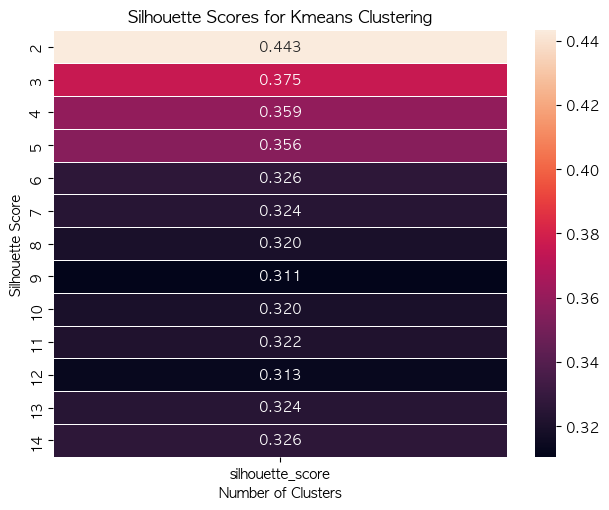

In [198]:
visualize_silhouette_scores(data_filter[['active_days', 'avg_daily_delivery', 'avg_distance', 'avg_fee' ]], method = 'kmeans')

In [202]:
random.seed(1234)
n_clusters = 2
km = KMeans(n_clusters = n_clusters, random_state = 22)
km.fit(data_filter[['active_days', 'avg_daily_delivery']])

centers = km.cluster_centers_
print(centers)

[[ 3.11755547  5.2312332 ]
 [ 5.10581395 20.08081395]]


Text(0.5, 1.0, 'Predicted')

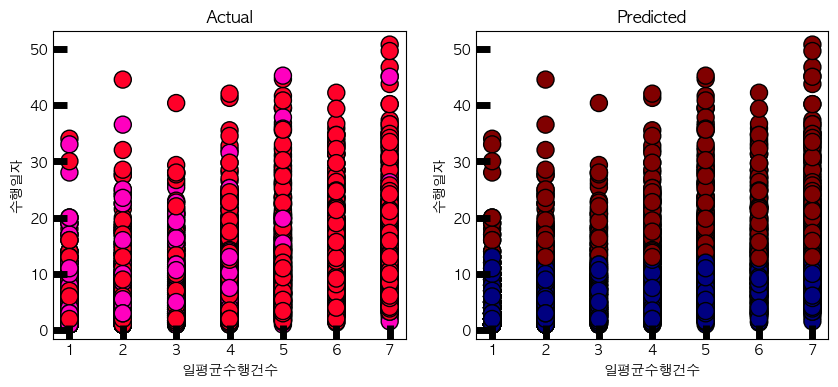

In [203]:
new_labels = km.labels_

#plot
fig,axes = plt.subplots(1,2,figsize = (10,4))
axes[0].scatter(data_filter['active_days'], data_filter['avg_daily_delivery'], c = data_filter['outcome'], cmap='gist_rainbow',edgecolor='k', s=150)
axes[1].scatter(data_filter['active_days'], data_filter['avg_daily_delivery'], c=new_labels, cmap='jet',edgecolor='k', s=150)

axes[0].set_xlabel('일평균수행건수', fontsize=10)
axes[0].set_ylabel('수행일자', fontsize=10)
axes[1].set_xlabel('일평균수행건수', fontsize=10)
axes[1].set_ylabel('수행일자', fontsize=10)

axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=10)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=10)

axes[0].set_title('Actual', fontsize=12)
axes[1].set_title('Predicted', fontsize=12)

## 2-2. DBSCAN (Density-based Spatial Clustering of Applications with Noise)

##### def visualize_dbscan : 클러스터링이 유효할 조건으로 클러스터 내에 여러 개의 포인트가 있어야 하며, 노이즈(-1)를 제외한 클러스터가 존재해야 함. 만약 클러스터링 결과가 이 조건을 만족하지 않으면 실루엣 점수를 -1로 설정

##### def find_best_parameter_dbscan : 클러스터 내의 응집력과 클러스터 간의 분리도를 모두 고려함. 노이즈가 많은 클러스터링 설정에서도 실루엣 점수를 평가함. 

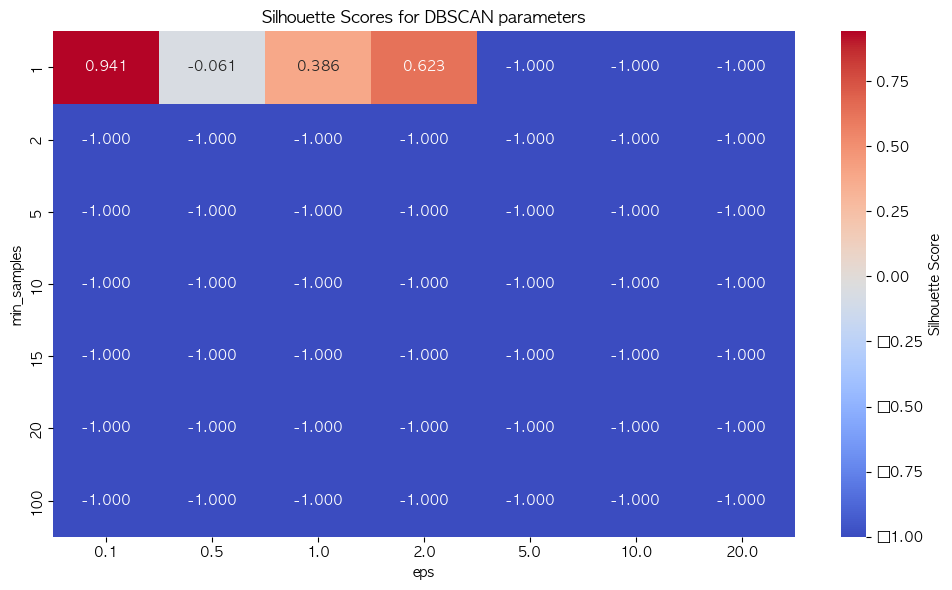

In [224]:
def visualize_dbscan(data, eps_values, min_samples_values):
   
    results = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)

            # 노이즈만 있는 경우(-1) 점수를 계산하지 않습니다.
            if len(set(labels)) > 1 and -1 not in set(labels):
                score = silhouette_score(data, labels)
            else:
                score = -1  # 유효하지 않은 클러스터링을 나타냄
            
            # 결과 리스트에 추가
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette_score': score
            })

    results_df = pd.DataFrame(results)
    results_pivot = results_df.pivot(index="min_samples", columns="eps", values="silhouette_score")

    # 히트맵
    plt.figure(figsize=(10, 6))
    sns.heatmap(results_pivot, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Silhouette Score'})
    plt.title("Silhouette Scores for DBSCAN parameters")
    plt.tight_layout()
    plt.show()

epsilon = [0.1, 0.5, 1, 2, 5, 10, 20]
min_samples = [1,2,5,10,15,20,100]

visualize_dbscan(data_filter[['active_days', 'avg_daily_delivery']], epsilon, min_samples)

In [222]:
epsilon = [1,1.25,1.5,1.75, 2,2.25,2.5,2.75, 3,3.25,3.5,3.75, 4]
min_samples = [10,15,20,25,50,100,500]

def find_best_parameter_dbscan(data):
    sil_avg = []
    max_value = [0,0,0,0]

    for i in range(len(epsilon)):
        for j in range(len(min_samples)):
            
            db = DBSCAN(min_samples = min_samples[j], eps = epsilon[i]).fit(data)
            core_samples_mask = np.zeros_like(db.labels_, dtype= bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_
            
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            #n_noise_ = list(labels).count(-1)
        
            silhouette_avg = metrics.silhouette_score(data, labels)
            
            if silhouette_avg > max_value[3] :
                max_value = (epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
            sil_avg.append(silhouette_avg)
                     
    return ("epsilon=", max_value[0], "min_sample=", max_value[1], "number of clusters=", max_value[2], "average silhouette score= %.4f" % max_value[3])

db_df = data_filter[['active_days', 'avg_daily_delivery']]
find_best_parameter_dbscan(db_df)

('epsilon=',
 3.25,
 'min_sample=',
 10,
 'number of clusters=',
 1,
 'average silhouette score= 0.7523')

In [227]:
# apply DBSCAN 

db = DBSCAN(eps=3.25, min_samples=500).fit(db_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(db_df, labels))

Estimated number of clusters: 1
Estimated number of noise points: 525
Silhouette Coefficient: 0.622


In [212]:
# apply DBSCAN
dbscan_cluster = DBSCAN(eps = 10, min_samples=100)
predicted_labels = dbscan_cluster.fit_predict(db_df)

predict_df = pd.DataFrame(predicted_labels, columns=['predict'])
print(predict_df['predict'].value_counts())
#result_df = pd.concat([cluster_df, predict_df], axis = 1)

#print(result_df)


predict
 0    3427
-1       2
Name: count, dtype: int64
